In [1]:
# pip install nltk textblob
# pip install --upgrade scipy

In [2]:
import warnings
import pandas as pd
import pyspark.sql.functions as fn
from datetime import datetime
from pyspark.sql.functions import split, explode, udf, col, size, expr, to_date, avg, count, when, isnan, to_timestamp, window, date_format
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, BooleanType, ArrayType, TimestampType, FloatType
import nltk
from nltk.corpus import stopwords
import re
import string
from textblob import TextBlob
from datetime import date, timedelta
import pymongo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
write_config = {
    "uri": "mongodb://localhost:27017/CA2.raw_tweets?retryWrites=true&w=majority",
    "database": "CA2",
    "raw_collection": "raw_tweets",
    "modified_collection": "modified_tweets",
    "aggregates_collection": "daily_data",
    "writeConcern.w": "majority"
}

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load the data from mongoDB
rawTweetsDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", write_config["raw_collection"])\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()

In [5]:
rawTweetsDF.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- user: string (nullable = true)



In [6]:
rawTweetsDF.toPandas().head()

,_id,date,flag,tweet,tweet_id,user
0,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1467810369,_TheSpecialOne_
1,1,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,is upset that he can't update his Facebook by ...,1467810672,scotthamilton
2,2,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,@Kenichan I dived many times for the ball. Man...,1467810917,mattycus
3,3,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,my whole body feels itchy and like its on fire,1467811184,ElleCTF
4,4,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,"@nationwideclass no, it's not behaving at all....",1467811193,Karoli


In [7]:
rawTweetsDF.count()

1600000

### Check for null values

In [8]:
# This will check the percentage of null values in the dataset in each columns
missingDF = rawTweetsDF.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_miss')
    for c in rawTweetsDF.columns
]).toPandas()

In [9]:
missingDF.melt()

,variable,value
0,_id_miss,0.0
1,date_miss,0.0
2,flag_miss,0.0
3,tweet_miss,0.0
4,tweet_id_miss,0.0
5,user_miss,0.0


### Check for duplicates

In [10]:
distinctDF = rawTweetsDF.select("tweet_id").distinct()

In [11]:
distinctDF.count()

1598315

In [12]:
rawTweetsDF.select("tweet_id").count()

1600000

In [13]:
# Retrieve a sample of duplicate records for visual purposes
notDuplicateRecordsDF = rawTweetsDF.groupBy("tweet_id").count().where("count = 1").drop("count")
duplicateRecordsDF = rawTweetsDF.join(notDuplicateRecordsDF, on="tweet_id", how="left_anti").limit(6)

In [14]:
duplicateRecordsDF.toPandas().head(6)

,tweet_id,_id,date,flag,tweet,user
0,1468053611,989,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,@hellobebe I also send some updates in plurk b...,mariejamora
1,1468053611,801280,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,@hellobebe I also send some updates in plurk b...,mariejamora
2,1468100580,1177,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,good night swetdreamss to everyonee and jare...,cristygarza
3,1468100580,801573,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,good night swetdreamss to everyonee and jare...,cristygarza
4,1468131748,1333,Mon Apr 06 23:53:22 PDT 2009,NO_QUERY,@gordonchiu You're one letter alway! Korean...,steveslee
5,1468131748,801794,Mon Apr 06 23:53:22 PDT 2009,NO_QUERY,@gordonchiu You're one letter alway! Korean...,steveslee


Since there are duplicate tweets in the dataset, we'll be removing it so that it won't cause an issue when training the model.

In [15]:
duplicatesRemovedDF = rawTweetsDF.dropDuplicates(["tweet_id"])
duplicatesRemovedDF.count()

1598315

In [16]:
rawTweetsDF = duplicatesRemovedDF;

## Data Preparation

This section shows the steps for the data preparation.

### Convert the date to Machine Readable Format
Convert the date to an array then use the array to create the date. The created timestamp will be used for aggregation in later steps.

In [17]:
# use a user defined function to convert the date and remove the time.
def convertToDate(s):
    # Split the date
    split = s.split(" ")
    # Create the timestamp
    newDate = datetime.strptime(f"{split[2]}-{split[1]}-{split[5]}", "%d-%b-%Y")
    return newDate.strftime("%Y-%m-%d")
    
convertToDateUDF = udf(convertToDate, StringType())

def convertToDateTime(s):
    # Split the date
    split = s.split(" ")
    # Create the timestamp
    newDate = datetime.strptime(f"{split[2]}-{split[1]}-{split[5]} {split[3]}", "%d-%b-%Y %H:%M:%S")
    return newDate.strftime("%Y-%m-%d %H:%M:%SZ")
    
convertToDateTimeUDF = udf(convertToDateTime, StringType())

In [18]:
# Create a timestamp from the date array
tempDateDF = rawTweetsDF.withColumn("date_converted", convertToDateUDF(rawTweetsDF["date"]))

In [19]:
tempDateDF.select("date_converted").limit(5).toPandas().head()

,date_converted
0,2009-04-06
1,2009-04-06
2,2009-04-06
3,2009-04-06
4,2009-04-06


In [20]:
tempDateDF.select("date_converted").toPandas().tail()

,date_converted
1598310,2009-06-25
1598311,2009-06-25
1598312,2009-06-25
1598313,2009-06-25
1598314,2009-06-25


In [21]:
tempDateDF.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- date_converted: string (nullable = true)



Getting the distinct date values reveals that there are missing dates from April 06 to June 25. This indicates that there will be data imputation for the time series data.

In [22]:
tempDateDF.select("date_converted").distinct().count()

48

In [23]:
tempDateDF = tempDateDF.withColumn("timestamp_converted", convertToDateTimeUDF(col("date")))

In [24]:
tempDateDF.select("timestamp_converted").show()

+--------------------+
| timestamp_converted|
+--------------------+
|2009-04-06 22:20:37Z|
|2009-04-06 22:21:04Z|
|2009-04-06 22:21:07Z|
|2009-04-06 22:21:21Z|
|2009-04-06 22:21:20Z|
|2009-04-06 22:22:07Z|
|2009-04-06 22:22:37Z|
|2009-04-06 22:22:46Z|
|2009-04-06 22:22:51Z|
|2009-04-06 22:22:53Z|
|2009-04-06 22:22:54Z|
|2009-04-06 22:22:58Z|
|2009-04-06 22:22:57Z|
|2009-04-06 22:22:56Z|
|2009-04-06 22:22:58Z|
|2009-04-06 22:23:00Z|
|2009-04-06 22:23:12Z|
|2009-04-06 22:23:21Z|
|2009-04-06 22:23:22Z|
|2009-04-06 22:23:25Z|
+--------------------+
only showing top 20 rows



In [25]:
rawTweetsDF = tempDateDF

### Tweet Cleaning and Preparation
This section cleans the tweets by removing the hashtags and user mentions. In addition, the section also computes the sentiment using nltk.

In [26]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Converts the tweet to lowercase
# Remove mentions and URLs since it doesn't contribute to the sentiment
# Removes symbols
# Removes stopwords
def processTweet (s):
    # Lowercase
    lowercaseText = s.lower()
    #Remove mentions and URLs
    processedText = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", lowercaseText)
    processedText = " ".join(processedText.split())
    
    # Convert contractions
    processedText = " ".join(decontracted(x) for x in processedText.split())
    
    # Remove numbers
    processedText = "".join([i for i in processedText if not i.isdigit()])
    
    # Remove punctuations
    removedSymbols = processedText.translate(str.maketrans('', '', string.punctuation)) #re.sub(r"[^\w\s]", "", processedText)
    
    # Remove stopwords
#     stop = stopwords.words('english')
#     text = " ".join(x for x in processedText.split() if x not in stop)
    
    return removedSymbols

processTweet = udf(processTweet)

In [27]:
modifiedTweetDF = rawTweetsDF.withColumn("modified_tweet", processTweet(rawTweetsDF["tweet"]))

In [28]:
modifiedTweetDF.select("modified_tweet").limit(5).toPandas().head(5)

,modified_tweet
0,i was out most of the day so did not get much ...
1,meh almost lover is the exception this track g...
2,i want to go to promote gear and groove but un...
3,i cry my asian eyes to sleep at night
4,ok i am sick and spent an hour sitting in the ...


In [29]:
# Getting sentiments of the tweets
def getSentiment(s):
    return TextBlob(s).sentiment[0]

getSentimentUDF = udf(getSentiment, FloatType())

In [30]:
modifiedTweetDF = modifiedTweetDF.withColumn("sentiment", getSentimentUDF(modifiedTweetDF["modified_tweet"]))

In [31]:
modifiedTweetDF.limit(5).toPandas().head()

,_id,date,flag,tweet,tweet_id,user,date_converted,timestamp_converted,modified_tweet,sentiment
0,20,Mon Apr 06 22:20:37 PDT 2009,NO_QUERY,@alydesigns i was out most of the day so didn'...,1467813985,quanvu,2009-04-06,2009-04-06 22:20:37Z,i was out most of the day so did not get much ...,0.350000
1,29,Mon Apr 06 22:21:04 PDT 2009,NO_QUERY,Meh... Almost Lover is the exception... this t...,1467815753,BaptisteTheFool,2009-04-06,2009-04-06 22:21:04Z,meh almost lover is the exception this track g...,0.000000
2,31,Mon Apr 06 22:21:07 PDT 2009,NO_QUERY,@alielayus I want to go to promote GEAR AND GR...,1467815924,EmCDL,2009-04-06,2009-04-06 22:21:07Z,i want to go to promote gear and groove but un...,0.000000
3,34,Mon Apr 06 22:21:21 PDT 2009,NO_QUERY,@HumpNinja I cry my asian eyes to sleep at night,1467816665,jsoo,2009-04-06,2009-04-06 22:21:21Z,i cry my asian eyes to sleep at night,0.000000
4,35,Mon Apr 06 22:21:20 PDT 2009,NO_QUERY,ok I'm sick and spent an hour sitting in the s...,1467816749,scarletletterm,2009-04-06,2009-04-06 22:21:20Z,ok i am sick and spent an hour sitting in the ...,-0.205714


Remove the columns that aren't needed in for time series analysis

In [32]:
# modifiedTweetDF = modifiedTweetDF.drop("date")
modifiedTweetDF = modifiedTweetDF.drop("flag")
modifiedTweetDF = modifiedTweetDF.drop("tweet")
modifiedTweetDF = modifiedTweetDF.drop("tweet_id")
modifiedTweetDF = modifiedTweetDF.drop("user")

In [33]:
modifiedTweetDF.limit(5).toPandas()

,_id,date,date_converted,timestamp_converted,modified_tweet,sentiment
0,20,Mon Apr 06 22:20:37 PDT 2009,2009-04-06,2009-04-06 22:20:37Z,i was out most of the day so did not get much ...,0.350000
1,29,Mon Apr 06 22:21:04 PDT 2009,2009-04-06,2009-04-06 22:21:04Z,meh almost lover is the exception this track g...,0.000000
2,31,Mon Apr 06 22:21:07 PDT 2009,2009-04-06,2009-04-06 22:21:07Z,i want to go to promote gear and groove but un...,0.000000
3,34,Mon Apr 06 22:21:21 PDT 2009,2009-04-06,2009-04-06 22:21:21Z,i cry my asian eyes to sleep at night,0.000000
4,35,Mon Apr 06 22:21:20 PDT 2009,2009-04-06,2009-04-06 22:21:20Z,ok i am sick and spent an hour sitting in the ...,-0.205714


Save the modified tweet dataframe to mongoDB. This will serve as a checkpoint incase there will be some modifications to the modified tweets.

In [35]:
modifiedTweetDF.write\
    .format("mongodb")\
    .mode("append")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "modified_tweets")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .save()

2023-11-13 21:05:45,617 WARN util.CaseInsensitiveStringMap: Converting duplicated key writeconcern.w into CaseInsensitiveStringMap.


Read the data saved from DB.

In [2]:
modifiedTweetDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", write_config["modified_collection"])\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()\
    .sort("timestamp_converted")

In [10]:
modifiedTweetDF.toPandas().describe()

,_id,sentiment
count,1.598315e+06,1.598315e+06
mean,7.995771e+05,9.309260e-02
std,4.618790e+05,3.288140e-01
min,0.000000e+00,-1.000000e+00
25%,3.995785e+05,0.000000e+00
50%,7.991570e+05,0.000000e+00
75%,1.199576e+06,2.716667e-01
max,1.599999e+06,1.000000e+00


In [11]:
modifiedTweetDF.select("modified_tweet", "sentiment").where("sentiment = -1").show()

+--------------------+---------+
|      modified_tweet|sentiment|
+--------------------+---------+
|i just saw that t...|     -1.0|
|yeah i know it wa...|     -1.0|
|ugh horrible endi...|     -1.0|
|is myki really ho...|     -1.0|
|that is horrible ...|     -1.0|
| weeks till siste...|     -1.0|
|sorting brekkie f...|     -1.0|
|dang i will get h...|     -1.0|
|horrible sore thr...|     -1.0|
|had the worst dre...|     -1.0|
|i cannot believe ...|     -1.0|
|had the worst dre...|     -1.0|
|    itï¿½s so boring|     -1.0|
|i treated myself ...|     -1.0|
|having a horrible...|     -1.0|
|a lot of people s...|     -1.0|
|i see you escaped...|     -1.0|
|nawww take me to ...|     -1.0|
|well facebook is ...|     -1.0|
|oh did you see th...|     -1.0|
+--------------------+---------+
only showing top 20 rows



In [12]:
modifiedTweetDF = modifiedTweetDF.withColumn("timestamp_converted", to_timestamp(col("timestamp_converted")))
# resample_df = modifiedTweetDF.groupBy(F.window("date"))

In [13]:
modifiedTweetDF.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- date_converted: string (nullable = true)
 |-- modified_tweet: string (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- timestamp_converted: timestamp (nullable = true)



### Resampling of Data

In [14]:
resampleDF = modifiedTweetDF.groupBy(window("timestamp_converted", "1 hour"))\
    .agg(
        avg(col("sentiment")).alias("average_sentiment"),
#         count(col("sentiment")).alias("total_tweet"),
        (count(when(col("sentiment") > 0, col("sentiment"))) / count(col("sentiment"))).alias("positive_tweet_ratio"),
        (count(when(col("sentiment") == 0, col("sentiment"))) / count(col("sentiment"))).alias("neutral_tweet_ratio"),
        (count(when(col("sentiment") < 0, col("sentiment"))) / count(col("sentiment"))).alias("negative_tweet_ratio"),
    )\
    .orderBy("window")

In [15]:
resampleDF.show(5)

+--------------------+-------------------+--------------------+-------------------+--------------------+
|              window|  average_sentiment|positive_tweet_ratio|neutral_tweet_ratio|negative_tweet_ratio|
+--------------------+-------------------+--------------------+-------------------+--------------------+
|{2009-04-06 23:00...|0.08722693897745153| 0.43671354552183567| 0.3404885270170244| 0.22279792746113988|
|{2009-04-07 00:00...|0.10596584664872526|   0.455317024463305|0.34997503744383424| 0.19470793809286072|
|{2009-04-07 01:00...|0.10918263228159161| 0.43830665978316985|0.36293236964377906| 0.19876097057305112|
|{2009-04-07 02:00...|0.10854907284392278| 0.44455852156057496| 0.3593429158110883| 0.19609856262833675|
|{2009-04-07 03:00...| 0.1085436496707588| 0.44750795334040294|   0.35949098621421| 0.19300106044538706|
+--------------------+-------------------+--------------------+-------------------+--------------------+
only showing top 5 rows



In [16]:
resampleDF = resampleDF.withColumn("date", date_format(col("window.start"), "yyyy-MM-dd HH:mm:ss"))
resampleDF = resampleDF.drop("window")

In [17]:
resampleDF.printSchema()

root
 |-- average_sentiment: double (nullable = true)
 |-- positive_tweet_ratio: double (nullable = true)
 |-- neutral_tweet_ratio: double (nullable = true)
 |-- negative_tweet_ratio: double (nullable = true)
 |-- date: string (nullable = true)



At this point, the pyspark dataframe will converted to pandas dataframe to make it easier to visualize the data and perform imputations

In [18]:
resampledPDF = resampleDF.toPandas()

In [19]:
resampledPDF.head()

,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio,date
0,0.087227,0.436714,0.340489,0.222798,2009-04-06 23:00:00
1,0.105966,0.455317,0.349975,0.194708,2009-04-07 00:00:00
2,0.109183,0.438307,0.362932,0.198761,2009-04-07 01:00:00
3,0.108549,0.444559,0.359343,0.196099,2009-04-07 02:00:00
4,0.108544,0.447508,0.359491,0.193001,2009-04-07 03:00:00


In [20]:
def createLinePlot(dataSet, title, legend = []):
    plt.rcParams['figure.figsize']=(15,7)
    plt.plot(dataSet)
    plt.xticks(dataSet.index[::200])
    plt.title(title)
    plt.legend(legend)
    plt.show()

In [21]:
resampledPDF['date'] = pd.to_datetime(resampledPDF['date'], format="%Y-%m-%d %H:%M:%S")
resampledPDF = resampledPDF.set_index('date')
resampledPDF.head()

,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio
date,,,,
2009-04-06 23:00:00,0.087227,0.436714,0.340489,0.222798
2009-04-07 00:00:00,0.105966,0.455317,0.349975,0.194708
2009-04-07 01:00:00,0.109183,0.438307,0.362932,0.198761
2009-04-07 02:00:00,0.108549,0.444559,0.359343,0.196099
2009-04-07 03:00:00,0.108544,0.447508,0.359491,0.193001


In [22]:
resampledPDF = resampledPDF.resample(rule="H", label="right").mean()

In [23]:
resampledPDF.head()

,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio
date,,,,
2009-04-07 00:00:00,0.087227,0.436714,0.340489,0.222798
2009-04-07 01:00:00,0.105966,0.455317,0.349975,0.194708
2009-04-07 02:00:00,0.109183,0.438307,0.362932,0.198761
2009-04-07 03:00:00,0.108549,0.444559,0.359343,0.196099
2009-04-07 04:00:00,0.108544,0.447508,0.359491,0.193001


### Checking of null values

In [24]:
resampledPDF.isnull().sum()

average_sentiment       1316
positive_tweet_ratio    1316
neutral_tweet_ratio     1316
negative_tweet_ratio    1316
dtype: int64

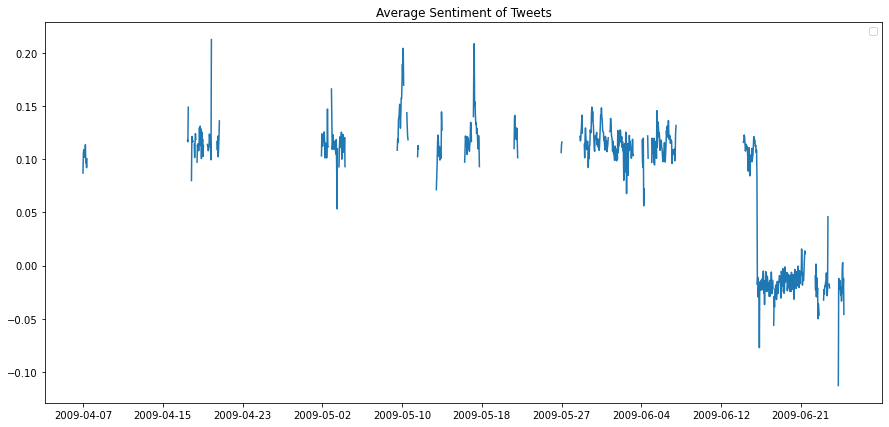

In [25]:
aveTempDF = resampledPDF[["average_sentiment"]]
createLinePlot(aveTempDF, "Average Sentiment of Tweets")

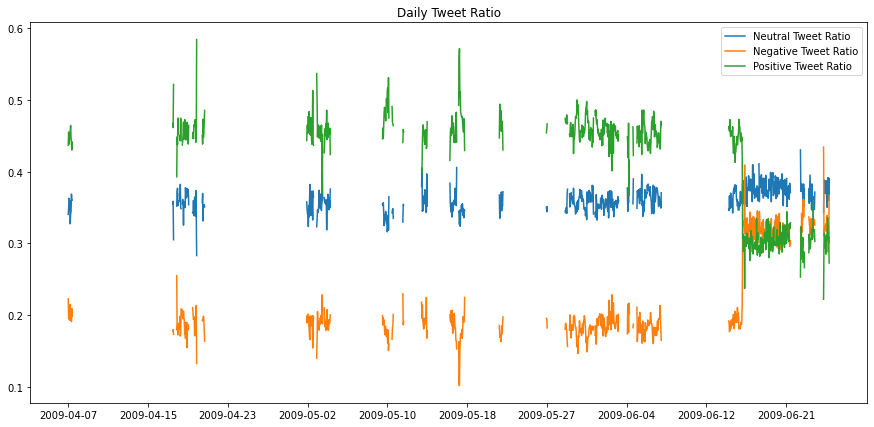

In [26]:
countTempDF = resampledPDF[["neutral_tweet_ratio", "negative_tweet_ratio", "positive_tweet_ratio"]]
createLinePlot(countTempDF, "Daily Tweet Ratio", ["Neutral Tweet Ratio", "Negative Tweet Ratio", "Positive Tweet Ratio"])

### Imputing data using KNN

Based on the graph, there are missing values in between the actualy data. KNN will be used. The date index is also reset and included in the columns since the KNN Imputer uses the mean with the absence of the date.

Check first the correlation to see which feature affects the average sentiment.

In [27]:
resampledPDF.describe()

,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio
count,593.000000,593.000000,593.000000,593.000000
mean,0.080080,0.415733,0.361634,0.222633
std,0.062106,0.071624,0.017224,0.062164
min,-0.112971,0.222222,0.283186,0.102041
25%,-0.002858,0.325455,0.350453,0.181398
50%,0.109700,0.448448,0.360286,0.193015
75%,0.119096,0.463514,0.372983,0.301199
max,0.212894,0.584071,0.430380,0.434343


In [40]:
corrResampled = hourly[["negative_tweet_ratio", "positive_tweet_ratio", "neutral_tweet_ratio", "average_sentiment"]]

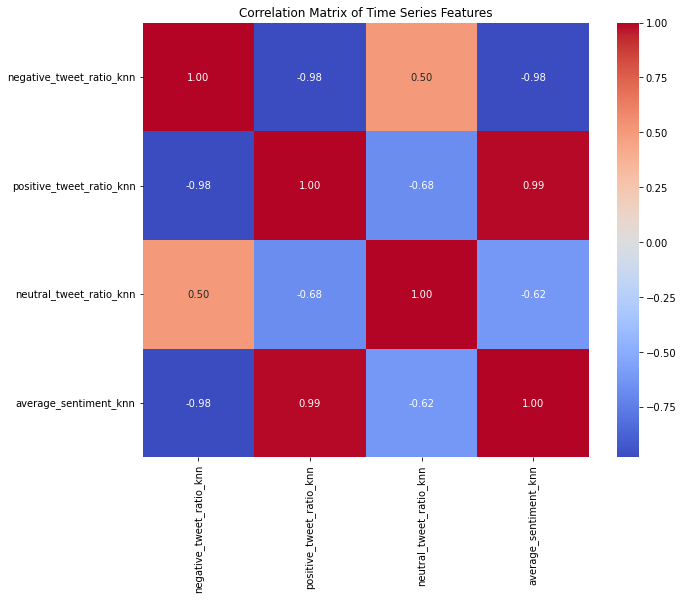

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Time Series Features')
plt.show()

In [59]:
import pandas as pd
from sklearn.impute import KNNImputer
# https://www.techscience.com/cmc/v70n1/44403/pdf
def KNNImpute(columns, newColumns, dataset):
    tempData = dataset[columns]
    tempData = tempData.reset_index()
    tempData["date"] = tempData["date"].values.astype("float64")
    knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
    imputed = knn_imputer.fit_transform(tempData)
    df_imputed_subset = pd.DataFrame(imputed, columns=["date"] + newColumns, index=dataset.index)
    df_imputed_subset = df_imputed_subset.drop("date", axis=1)
    dataset = pd.concat([dataset, df_imputed_subset], axis=1)
    return dataset

In [60]:
KNNImputedDF = KNNImpute(["average_sentiment", "positive_tweet_ratio", "negative_tweet_ratio", "neutral_tweet_ratio",], ["average_sentiment_knn", "positive_tweet_ratio_knn", "negative_tweet_ratio_knn", "neutral_tweet_ratio_knn"], resampledPDF)

In [61]:
KNNImputedDF.head()

,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio,average_sentiment_knn,positive_tweet_ratio_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn
date,,,,,,,,
2009-04-07 00:00:00,0.087227,0.436714,0.340489,0.222798,0.087227,0.436714,0.222798,0.340489
2009-04-07 01:00:00,0.105966,0.455317,0.349975,0.194708,0.105966,0.455317,0.194708,0.349975
2009-04-07 02:00:00,0.109183,0.438307,0.362932,0.198761,0.109183,0.438307,0.198761,0.362932
2009-04-07 03:00:00,0.108549,0.444559,0.359343,0.196099,0.108549,0.444559,0.196099,0.359343
2009-04-07 04:00:00,0.108544,0.447508,0.359491,0.193001,0.108544,0.447508,0.193001,0.359491


In [62]:
KNNImputedDF.dtypes

average_sentiment           float64
positive_tweet_ratio        float64
neutral_tweet_ratio         float64
negative_tweet_ratio        float64
average_sentiment_knn       float64
positive_tweet_ratio_knn    float64
negative_tweet_ratio_knn    float64
neutral_tweet_ratio_knn     float64
dtype: object

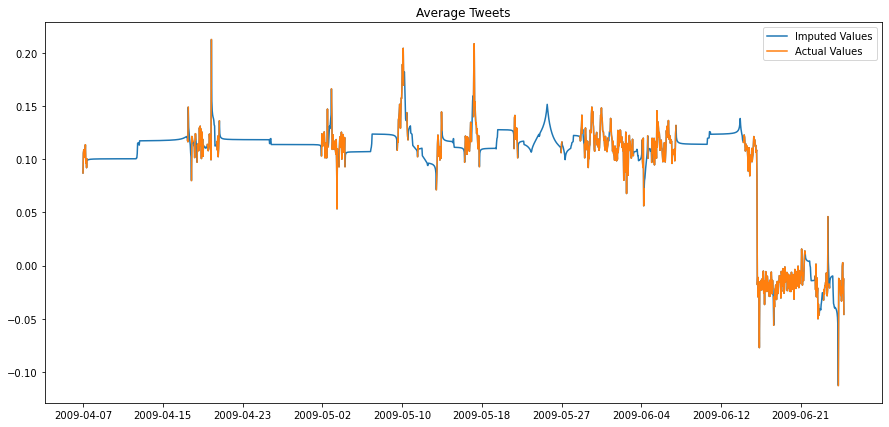

In [63]:
knnTemp = KNNImputedDF[["average_sentiment_knn", "average_sentiment"]]
createLinePlot(knnTemp, "Average Tweets", ["Imputed Values", "Actual Values"])

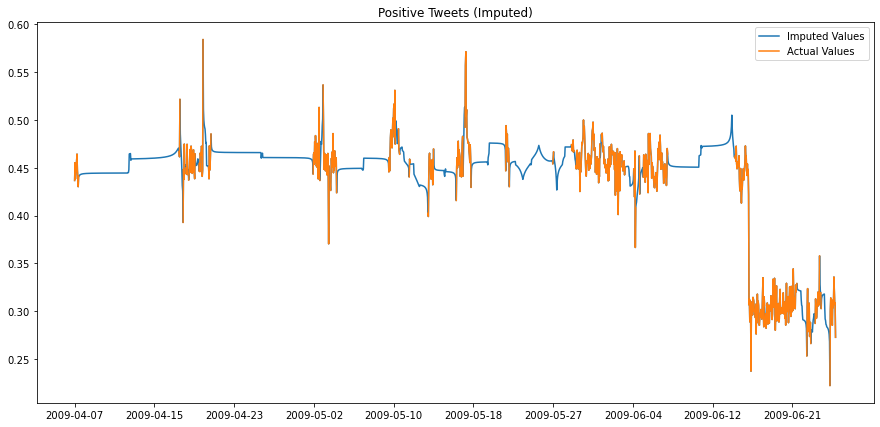

In [64]:
knnTemp2 = KNNImputedDF[["positive_tweet_ratio_knn", "positive_tweet_ratio"]]
createLinePlot(knnTemp2, "Positive Tweets (Imputed)", ["Imputed Values", "Actual Values"])

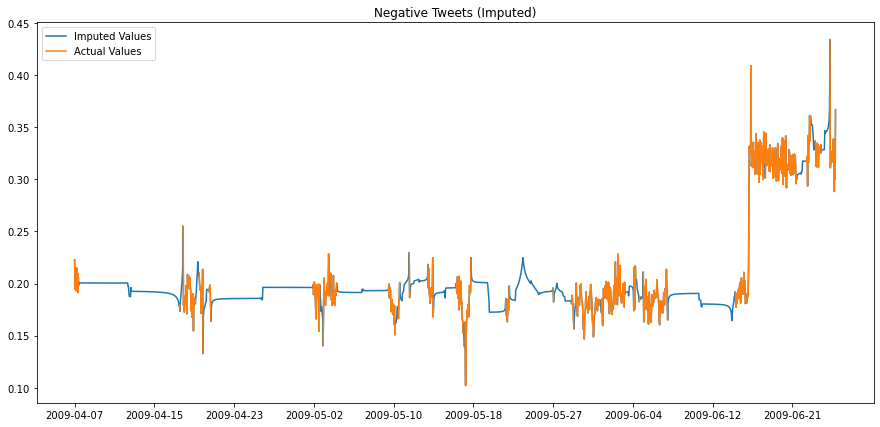

In [65]:
knnTemp3 = KNNImputedDF[["negative_tweet_ratio_knn", "negative_tweet_ratio"]]
createLinePlot(knnTemp3, "Negative Tweets (Imputed)", ["Imputed Values", "Actual Values"])

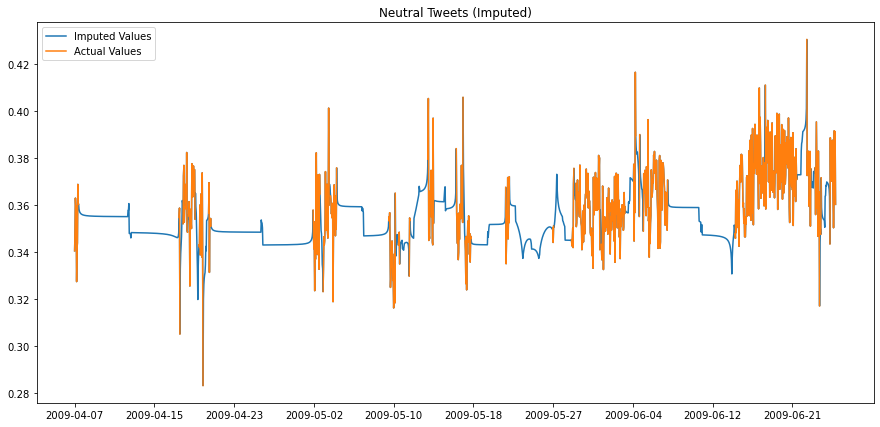

In [270]:
knnTemp4 = KNNImputedDF[["neutral_tweet_ratio_knn", "neutral_tweet_ratio"]]
createLinePlot(knnTemp4, "Neutral Tweets (Imputed)", ["Imputed Values", "Actual Values"])

In [278]:
copyDF = KNNImputedDF
copyDF = copyDF.reset_index()

In [279]:
copyDF

,date,average_sentiment,positive_tweet_ratio,neutral_tweet_ratio,negative_tweet_ratio,average_sentiment_knn,positive_tweet_ratio_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn
0,2009-04-07 00:00:00,0.087227,0.436714,0.340489,0.222798,0.087227,0.436714,0.222798,0.340489
1,2009-04-07 01:00:00,0.105966,0.455317,0.349975,0.194708,0.105966,0.455317,0.194708,0.349975
2,2009-04-07 02:00:00,0.109183,0.438307,0.362932,0.198761,0.109183,0.438307,0.198761,0.362932
3,2009-04-07 03:00:00,0.108549,0.444559,0.359343,0.196099,0.108549,0.444559,0.196099,0.359343
4,2009-04-07 04:00:00,0.108544,0.447508,0.359491,0.193001,0.108544,0.447508,0.193001,0.359491
...,...,...,...,...,...,...,...,...,...
1904,2009-06-25 08:00:00,-0.000616,0.335766,0.360584,0.303650,-0.000616,0.335766,0.303650,0.360584
1905,2009-06-25 09:00:00,0.002774,0.319981,0.391612,0.288407,0.002774,0.319981,0.288407,0.391612
1906,2009-06-25 10:00:00,-0.025827,0.306991,0.367275,0.325735,-0.025827,0.306991,0.325735,0.367275
1907,2009-06-25 11:00:00,-0.012120,0.308767,0.391137,0.300096,-0.012120,0.308767,0.300096,0.391137


In [280]:
copyDF.iteritems = copyDF.items
copySparkDF = spark.createDataFrame(copyDF)

In [281]:
copySparkDF.show()

+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------+------------------------+------------------------+-----------------------+
|               date|  average_sentiment|positive_tweet_ratio|neutral_tweet_ratio|negative_tweet_ratio|average_sentiment_knn|positive_tweet_ratio_knn|negative_tweet_ratio_knn|neutral_tweet_ratio_knn|
+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------+------------------------+------------------------+-----------------------+
|2009-04-07 00:00:00|0.08722693897745153| 0.43671354552183567| 0.3404885270170244| 0.22279792746113988|  0.08722693897745153|     0.43671354552183567|     0.22279792746113988|     0.3404885270170244|
|2009-04-07 01:00:00|0.10596584664872526|   0.455317024463305|0.34997503744383424| 0.19470793809286072|  0.10596584664872526|       0.455317024463305|     0.19470793809286072|    0.34997503744383424|


In [282]:
copySparkDF.write\
    .format("mongodb")\
    .mode("append")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "hourly_data_imputed")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .save()

2023-11-14 00:53:05,117 WARN util.CaseInsensitiveStringMap: Converting duplicated key writeconcern.w into CaseInsensitiveStringMap.


Read from database again since this is a checkpoint.

In [27]:
hourlyDataDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "hourly_data_imputed")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()\
    .sort("date")

In [28]:
hourlyDataDF.select("date", "average_sentiment").show()

+-------------------+-------------------+
|               date|  average_sentiment|
+-------------------+-------------------+
|2009-04-07 00:00:00|0.08722693897745153|
|2009-04-07 01:00:00|0.10596584664872526|
|2009-04-07 02:00:00|0.10918263228159161|
|2009-04-07 03:00:00|0.10854907284392278|
|2009-04-07 04:00:00| 0.1085436496707588|
|2009-04-07 05:00:00|0.10187704632578624|
|2009-04-07 06:00:00|0.11382896799416324|
|2009-04-07 07:00:00|0.09670449638509315|
|2009-04-07 08:00:00|0.10012214445880409|
|2009-04-07 09:00:00| 0.0921854104584707|
|2009-04-07 10:00:00|0.10047174739845502|
|2009-04-07 11:00:00|                NaN|
|2009-04-07 12:00:00|                NaN|
|2009-04-07 13:00:00|                NaN|
|2009-04-07 14:00:00|                NaN|
|2009-04-07 15:00:00|                NaN|
|2009-04-07 16:00:00|                NaN|
|2009-04-07 17:00:00|                NaN|
|2009-04-07 18:00:00|                NaN|
|2009-04-07 19:00:00|                NaN|
+-------------------+-------------

In [29]:
hourly = hourlyDataDF.withColumn("date", date_format("date", "yyyy-MM-dd HH:mm:ss")).toPandas()

In [30]:
hourly.head(20)

,_id,average_sentiment,average_sentiment_knn,date,negative_tweet_ratio,negative_tweet_ratio_knn,neutral_tweet_ratio,neutral_tweet_ratio_knn,positive_tweet_ratio,positive_tweet_ratio_knn
0,6552c4f1d7f5060e848fa7c5,0.087227,0.087227,2009-04-07 00:00:00,0.222798,0.222798,0.340489,0.340489,0.436714,0.436714
1,6552c4f1d7f5060e848fa7c6,0.105966,0.105966,2009-04-07 01:00:00,0.194708,0.194708,0.349975,0.349975,0.455317,0.455317
2,6552c4f1d7f5060e848fa7c7,0.109183,0.109183,2009-04-07 02:00:00,0.198761,0.198761,0.362932,0.362932,0.438307,0.438307
3,6552c4f1d7f5060e848fa7c8,0.108549,0.108549,2009-04-07 03:00:00,0.196099,0.196099,0.359343,0.359343,0.444559,0.444559
4,6552c4f1d7f5060e848fa7c9,0.108544,0.108544,2009-04-07 04:00:00,0.193001,0.193001,0.359491,0.359491,0.447508,0.447508
5,6552c4f1d7f5060e848fa7ca,0.101877,0.101877,2009-04-07 05:00:00,0.215015,0.215015,0.327375,0.327375,0.457610,0.457610
6,6552c4f1d7f5060e848fa7cb,0.113829,0.113829,2009-04-07 06:00:00,0.194472,0.194472,0.341206,0.341206,0.464322,0.464322
7,6552c4f1d7f5060e848fa7cc,0.096704,0.096704,2009-04-07 07:00:00,0.209023,0.209023,0.343860,0.343860,0.447118,0.447118
8,6552c4f1d7f5060e848fa7cd,0.100122,0.100122,2009-04-07 08:00:00,0.191251,0.191251,0.368769,0.368769,0.439980,0.439980
9,6552c4f1d7f5060e848fa7ce,0.092185,0.092185,2009-04-07 09:00:00,0.209207,0.209207,0.360614,0.360614,0.430179,0.430179


In [31]:
hourly.set_index("date", inplace=True)

In [32]:
stacked = hourly[["negative_tweet_ratio_knn", "positive_tweet_ratio_knn", "neutral_tweet_ratio_knn"]]

In [33]:
stacked["negative_tweet_ratio_knn"] = stacked["negative_tweet_ratio_knn"].round(2)
stacked["positive_tweet_ratio_knn"] = stacked["positive_tweet_ratio_knn"].round(2)
stacked["neutral_tweet_ratio_knn"] = stacked["neutral_tweet_ratio_knn"].round(2)

stacked = stacked.reset_index()
# stacked.drop("date", axis=1)

In [34]:
stacked.head()

,date,negative_tweet_ratio_knn,positive_tweet_ratio_knn,neutral_tweet_ratio_knn
0,2009-04-07 00:00:00,0.22,0.44,0.34
1,2009-04-07 01:00:00,0.19,0.46,0.35
2,2009-04-07 02:00:00,0.20,0.44,0.36
3,2009-04-07 03:00:00,0.20,0.44,0.36
4,2009-04-07 04:00:00,0.19,0.45,0.36


In [35]:
stacked.shape

(1909, 4)

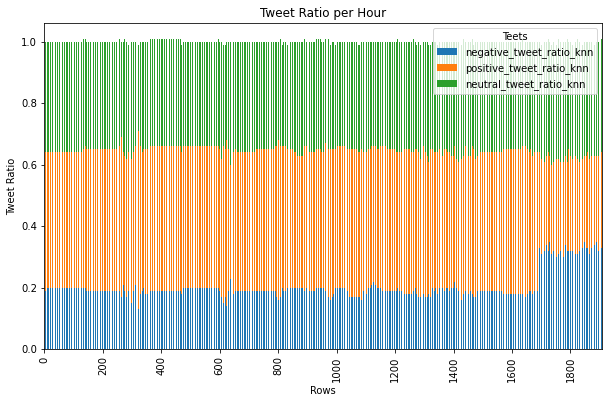

In [36]:
ax = stacked.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Rows')
plt.ylabel('Tweet Ratio')
plt.title('Tweet Ratio per Hour')
plt.xticks(stacked.index[::200])
# Adding legend
plt.legend(title='Teets', loc='upper right')

# Display the plot
plt.show()

# THESE AREN'T NEEDED ANYMORE

These are just testing some of the algorithms and ideas for imputation.

### Aggregating tweets

In this section, MongoDB was used to aggregate the data since PySpark is slow in aggregating the data. Indexes for date and sentiment were created in MonogDB to make querying faster.

In [245]:
tempPanda = modifiedTweetDF.select("date_converted").toPandas()

In [246]:
client = pymongo.MongoClient("localhost", 27017)
db = client.CA2

In [247]:
pipeline = [
    { 
        "$facet": {
            "aveSenti": [
                { "$group": { "_id": "$date_converted", "tweet_count": { "$sum": 1 }, "average_sentiment": { "$avg": "$sentiment" } } },
                { "$sort": { "_id": 1 } }
            ],
            "posiSenti": [
                { "$match": { "sentiment": { "$gt": 0 } } },
                { "$group": { "_id": "$date_converted", "positive_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            "negaSenti": [
                { "$match": { "sentiment": { "$lt": 0 } } },
                { "$group": { "_id": "$date_converted", "negative_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            "neuSenti": [
                { "$match": { "sentiment": { "$eq": 0 } } },
                { "$group": { "_id": "$date_converted", "neutral_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            
        } 
    }
]
# import pprint
# pprint.pprint(list())
databaseResponse = list(db.modified_tweets.aggregate(pipeline))

In [248]:
averageSentiment = databaseResponse[0]["aveSenti"];
positiveSentiment = databaseResponse[0]["posiSenti"];
negativeSentiment = databaseResponse[0]["negaSenti"];
neutralSentiment = databaseResponse[0]["neuSenti"];

In [249]:
def getSentiForDay(currDate, sentiPool):
    res = list(filter(lambda s: s['_id'] == currDate, sentiPool))
    return res[0] if len(res) > 0 else None

# Loop through the dates from the start date to the end date of the dataset
start_date = datetime.strptime(tempPanda["date_converted"][0], "%Y-%m-%d").date()
end_date = datetime.strptime(tempPanda["date_converted"][len(tempPanda) - 1], "%Y-%m-%d").date()
delta = timedelta(days=1)
data = []
while start_date <= end_date:
    currDate = start_date.strftime("%Y-%m-%d")
    currAveSenti = getSentiForDay(currDate, averageSentiment)
    currPosiSenti = getSentiForDay(currDate, positiveSentiment)
    currNegaSenti = getSentiForDay(currDate, negativeSentiment)
    currNeuSenti = getSentiForDay(currDate, neutralSentiment)
#     print(currAveSenti, currPosiSenti, currNegaSenti, currNeuSenti)
    
    tweetCount = np.nan
    aveSenti = np.nan
    posiSenti = np.nan
    negaSenti = np.nan
    neuSenti = np.nan
    
    if(currAveSenti):
        tweetCount = currAveSenti["tweet_count"]
        aveSenti = currAveSenti["average_sentiment"]
   
    if(currPosiSenti):
        posiSenti = currPosiSenti["positive_senti_count"]
    
    if(currNegaSenti):
        negaSenti = currNegaSenti["negative_senti_count"]
        
    if(currNeuSenti):
        neuSenti = currNeuSenti["neutral_senti_count"]
        
    row = [currDate, tweetCount, aveSenti, posiSenti, posiSenti/tweetCount if posiSenti else np.nan, negaSenti, negaSenti/tweetCount if negaSenti else np.nan, neuSenti, neuSenti/tweetCount if neuSenti else np.nan]
    data.append(row)
    start_date += delta

In [250]:
columns = ["date", "tweet_count", "average_sentiment", "positive_count", "positive_ratio", "negative_count", "negative_ratio", "neutral_count", "neutral_ratio"]

In [251]:
tsPDF = pd.DataFrame(data, columns=columns)
tsPDF.iteritems = tsPDF.items

In [252]:
tsSDF = spark.createDataFrame(tsPDF)

In [253]:
# tsSDF.write\
#     .format("mongodb")\
#     .mode("append")\
#     .option("uri", write_config["uri"])\
#     .option("database", write_config["database"])\
#     .option("collection", write_config["aggregates_collection"])\
#     .option("writeConcern.w", write_config["writeConcern.w"])\
#     .save()

In [254]:
# This is a code for loading the daily data. 
# The daily data is already saved to MongoDB as a sort of checkpoint 
# in case the EDA got interrupted or was stopped.
# tsSDF = spark.read\
#     .format("mongodb")\
#     .option("uri", write_config["uri"])\
#     .option("database", write_config["database"])\
#     .option("collection", write_config["aggregates_collection"])\
#     .option("writeConcern.w", write_config["writeConcern.w"])\
#     .load()\
#     .sort("date")

In [255]:
tsSDF.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet_count: double (nullable = true)
 |-- average_sentiment: double (nullable = true)
 |-- positive_count: double (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- negative_count: double (nullable = true)
 |-- negative_ratio: double (nullable = true)
 |-- neutral_count: double (nullable = true)
 |-- neutral_ratio: double (nullable = true)



In [256]:
# This will check the percentage of null values in the dataset in each columns
NaNPercentage = (tsSDF.filter(isnan(col("average_sentiment"))).count() / tsSDF.count()) * 100
TotalMissingDates = tsSDF.filter(isnan(col("average_sentiment"))).count()
TotalDates = tsSDF.count()

In [257]:
NaNPercentage, TotalMissingDates, TotalDates

(40.74074074074074, 33, 81)

In [48]:
tempPanda = tsSDF.toPandas()

In [50]:
tempPanda.head()

,date,tweet_count,average_sentiment,positive_count,positive_ratio,negative_count,negative_ratio,neutral_count,neutral_ratio
0,2009-04-06,3354.0,0.098418,1502.0,0.447823,691.0,0.206023,1161.0,0.346154
1,2009-04-07,17289.0,0.103523,7707.0,0.445775,3469.0,0.200648,6113.0,0.353577
2,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


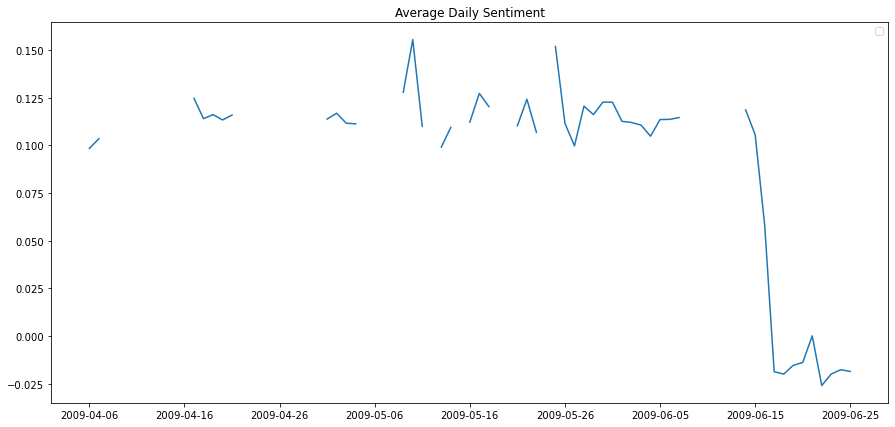

In [51]:
tempAve = tempPanda[["date", "average_sentiment"]]
tempAve.set_index("date", inplace=True)
createLinePlot(tempAve, "Average Daily Sentiment")

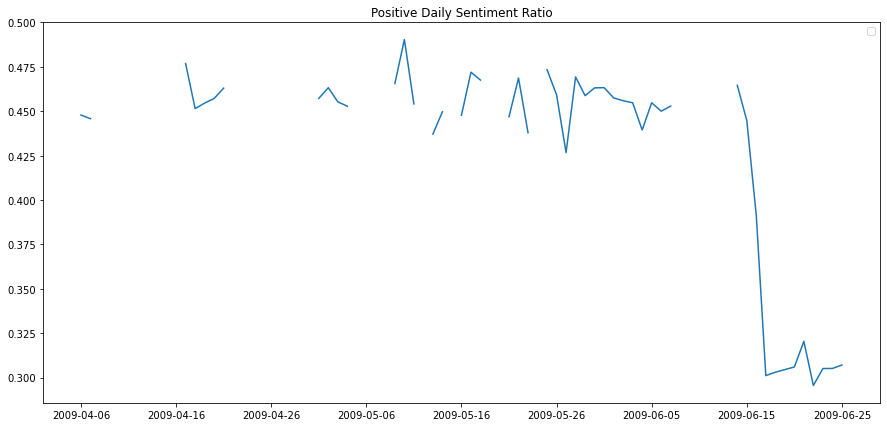

In [52]:
tempPosi = tempPanda[["date", "positive_ratio"]]
tempPosi.set_index("date", inplace=True)
createLinePlot(tempPosi, "Positive Daily Sentiment Ratio")

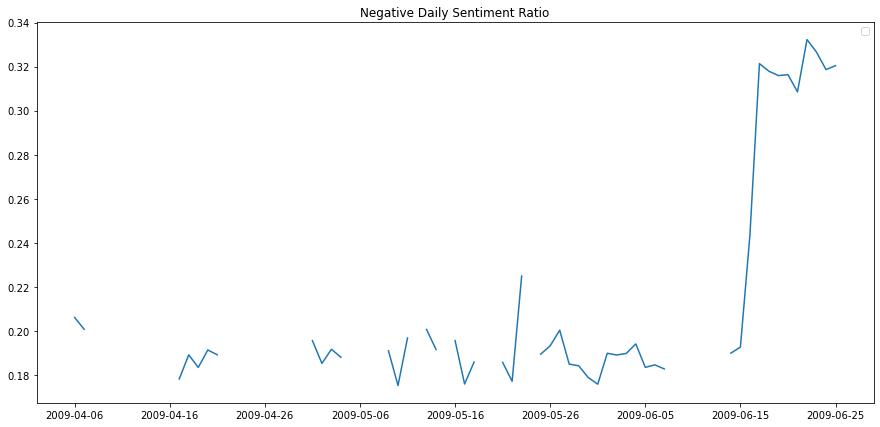

In [53]:
tempNega = tempPanda[["date", "negative_ratio"]]
tempNega.set_index("date", inplace=True)
createLinePlot(tempNega, "Negative Daily Sentiment Ratio")

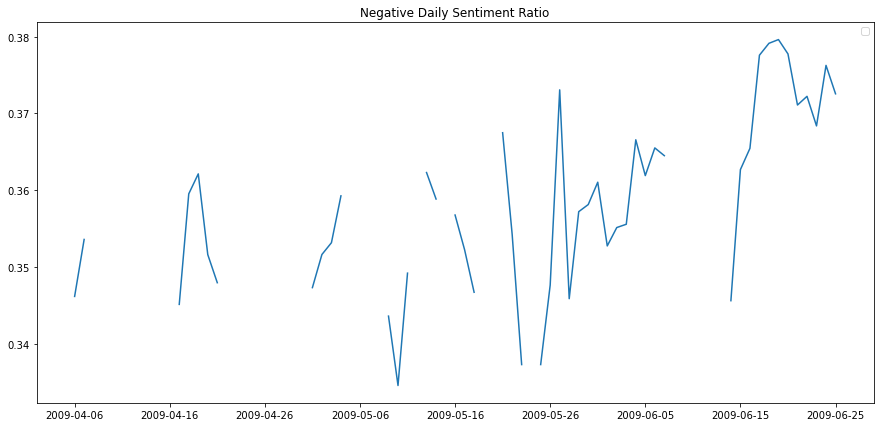

In [54]:
tempNeu = tempPanda[["date", "neutral_ratio"]]
tempNeu.set_index("date", inplace=True)
createLinePlot(tempNeu, "Negative Daily Sentiment Ratio")

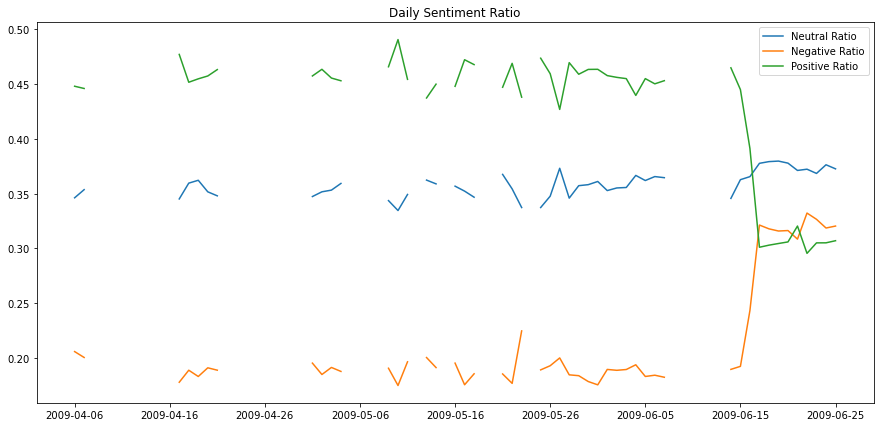

In [55]:
tempAllRatio = tempPanda[["date", "neutral_ratio", "negative_ratio", "positive_ratio"]]
tempAllRatio.set_index("date", inplace=True)
createLinePlot(tempAllRatio, "Daily Sentiment Ratio", ["Neutral Ratio", "Negative Ratio", "Positive Ratio"])

Spline with order 3 was used because this is commonly used for interpolation tasks. Higher interpolation order tends to overfit.

In [56]:
def splineInterpolate(column, newColumnName, dataset):
    dataset[newColumnName] = dataset[column].interpolate(method='spline', order=3)
    tempDS = tempPanda[["date", newColumnName, column,]]
    tempDS.set_index("date", inplace=True)
    return tempDS 

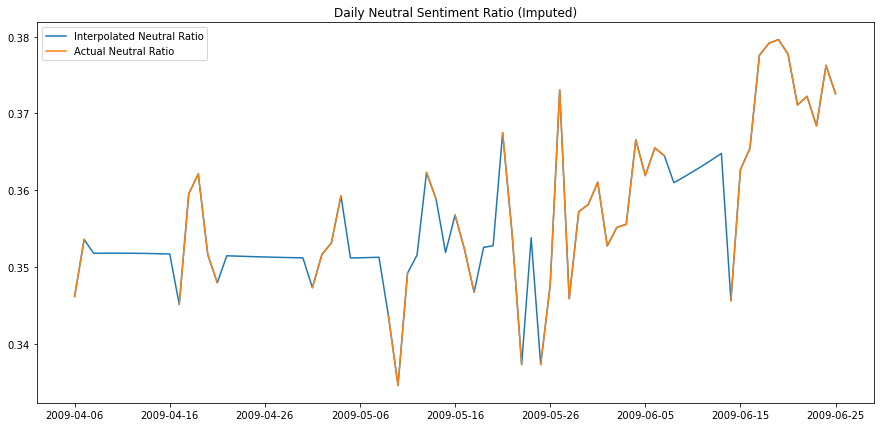

In [57]:
# tempPanda["neutral_interpolated"] = tempPanda["neutral_ratio"].interpolate(method='spline', order=3)
# tempNeuInterpolated = tempPanda[["date", "neutral_interpolated", "neutral_ratio",]]
# tempNeuInterpolated.set_index("date", inplace=True)
tempNeuInterpolated = splineInterpolate("neutral_ratio", "neutral_interpolated", tempPanda)
createLinePlot(tempNeuInterpolated, "Daily Neutral Sentiment Ratio (Imputed)", ["Interpolated Neutral Ratio", "Actual Neutral Ratio"])

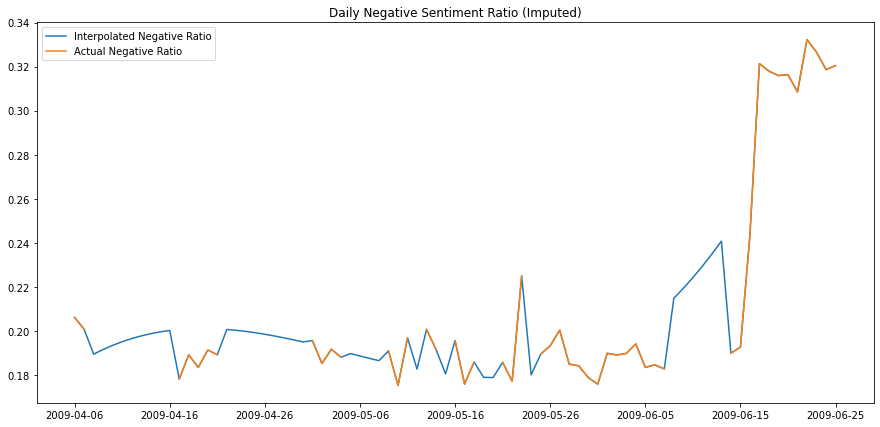

In [58]:
# tempPanda["negative_interpolated"] = tempPanda["negative_ratio"].interpolate(method='akima')
# tempNeuInterpolated = tempPanda[["date", "negative_interpolated", "negative_ratio",]]
# tempNeuInterpolated.set_index("date", inplace=True)
tempNegInterpolated = splineInterpolate("negative_ratio", "negative_interpolated", tempPanda)
createLinePlot(tempNegInterpolated, "Daily Negative Sentiment Ratio (Imputed)", ["Interpolated Negative Ratio", "Actual Negative Ratio"])

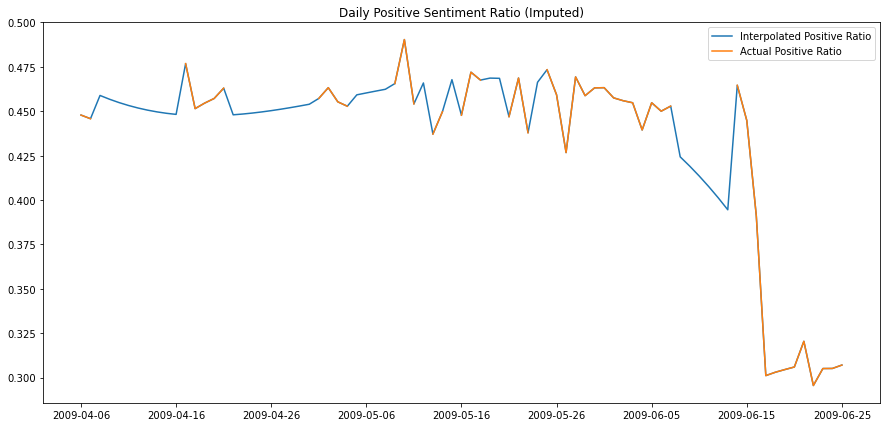

In [59]:
tempPosInterpolated = splineInterpolate("positive_ratio", "positive_interpolated", tempPanda)
createLinePlot(tempPosInterpolated, "Daily Positive Sentiment Ratio (Imputed)", ["Interpolated Positive Ratio", "Actual Positive Ratio"])

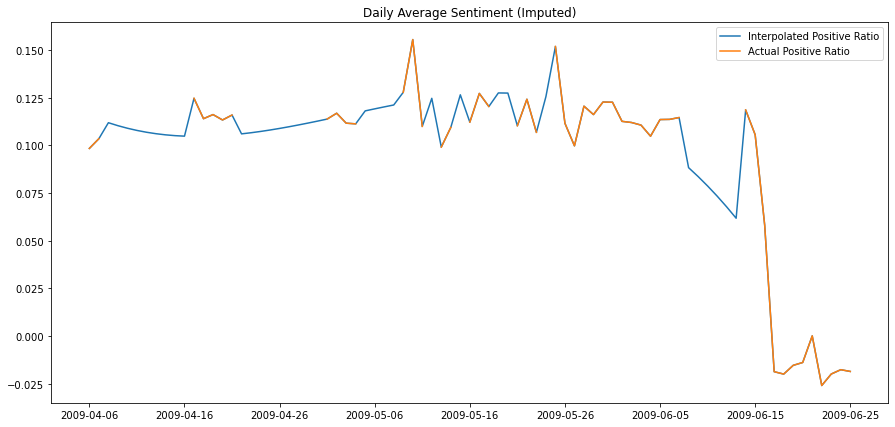

In [60]:
tempPosInterpolated = splineInterpolate("average_sentiment", "average_sentiment_interpolated", tempPanda)
createLinePlot(tempPosInterpolated, "Daily Average Sentiment (Imputed)", ["Interpolated Positive Ratio", "Actual Positive Ratio"])

In [61]:
tempPanda.head()

,date,tweet_count,average_sentiment,positive_count,positive_ratio,negative_count,negative_ratio,neutral_count,neutral_ratio,neutral_interpolated,negative_interpolated,positive_interpolated,average_sentiment_interpolated
0,2009-04-06,3354.0,0.098418,1502.0,0.447823,691.0,0.206023,1161.0,0.346154,0.346154,0.206023,0.447823,0.098418
1,2009-04-07,17289.0,0.103523,7707.0,0.445775,3469.0,0.200648,6113.0,0.353577,0.353577,0.200648,0.445775,0.103523
2,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351773,0.189355,0.458872,0.111898
3,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351786,0.191472,0.456742,0.110344
4,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351791,0.193350,0.454860,0.109000


In [62]:
import pandas as pd
from sklearn.impute import KNNImputer
# https://www.techscience.com/cmc/v70n1/44403/pdf
def KNNImpute(column, newColumn, dataset):
    tempData = dataset[["date", column]]
    tempData.set_index("date", inplace=True)
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed = knn_imputer.fit_transform(tempData)
    df_imputed_subset = pd.DataFrame(imputed, columns=[column])
    dataset[newColumn] = df_imputed_subset
    return df_imputed_subset

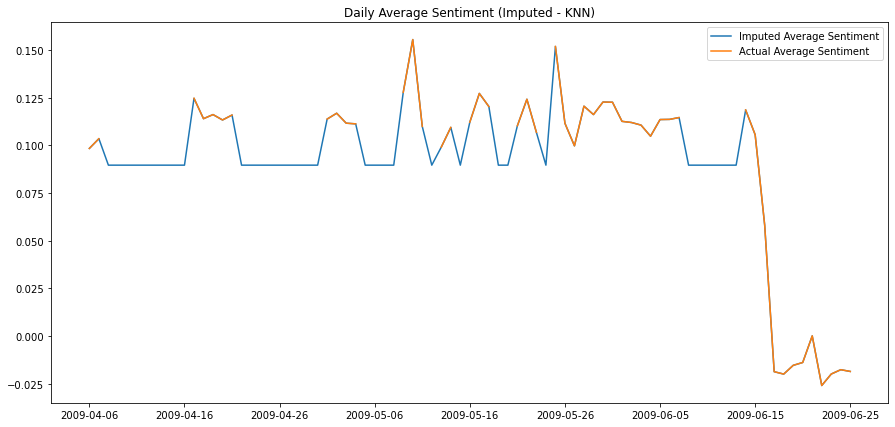

In [63]:
kNNAveDF = KNNImpute("average_sentiment", "average_sentiment_knn", tempPanda)
tempDS = tempPanda[["date", "average_sentiment_knn", "average_sentiment",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Average Sentiment (Imputed - KNN)", ["Imputed Average Sentiment", "Actual Average Sentiment"])

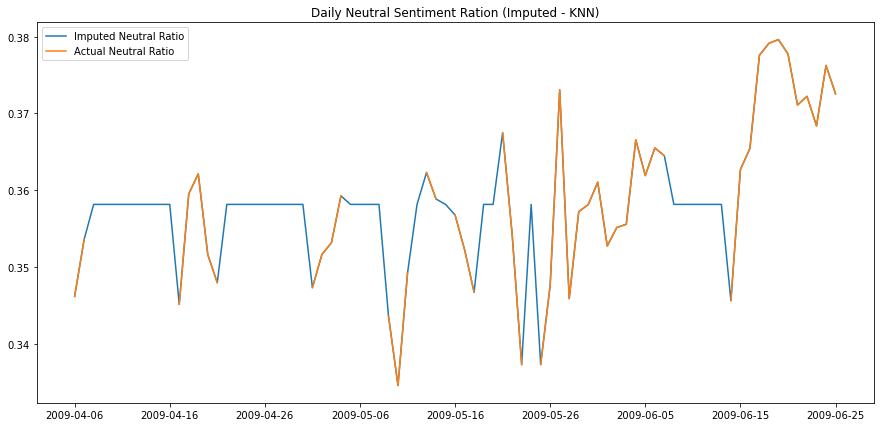

In [64]:
kNNAveDF = KNNImpute("neutral_ratio", "neutral_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "neutral_ratio_knn", "neutral_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Neutral Sentiment Ration (Imputed - KNN)", ["Imputed Neutral Ratio", "Actual Neutral Ratio"])

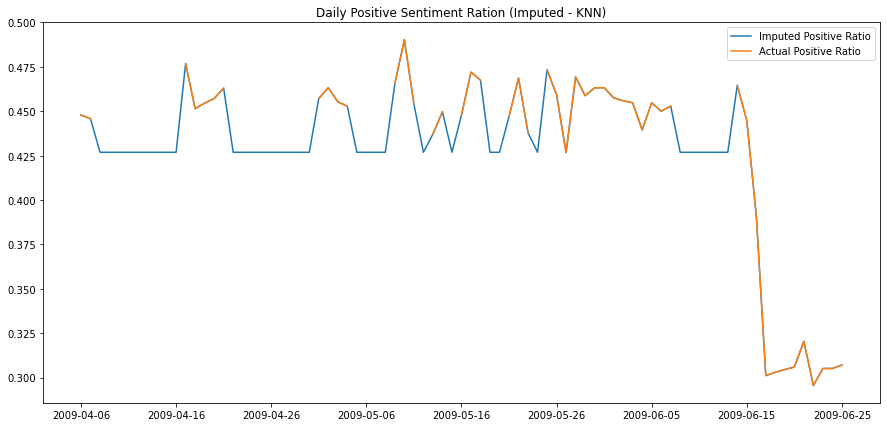

In [65]:
kNNAveDF = KNNImpute("positive_ratio", "positive_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "positive_ratio_knn", "positive_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Positive Sentiment Ration (Imputed - KNN)", ["Imputed Positive Ratio", "Actual Positive Ratio"])

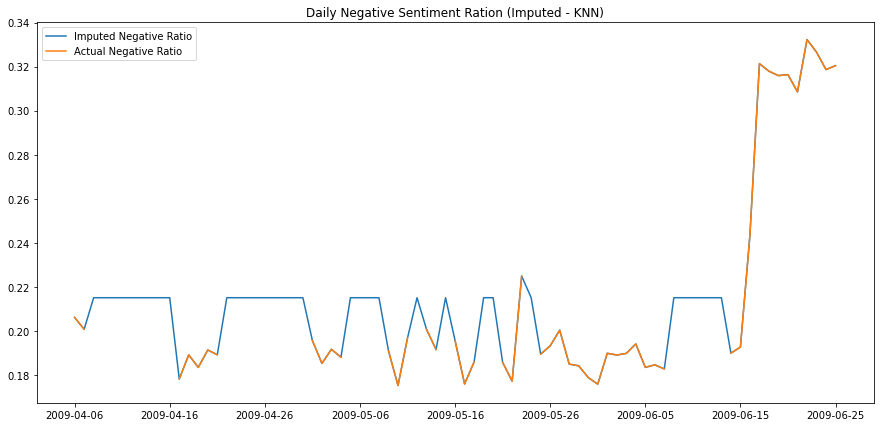

In [66]:
kNNAveDF = KNNImpute("negative_ratio", "negative_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "negative_ratio_knn", "negative_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Negative Sentiment Ration (Imputed - KNN)", ["Imputed Negative Ratio", "Actual Negative Ratio"])

In [68]:
# tempPanda.drop("neutral_akima_interpolated", inplace=True, axis=1)
tempPanda.head()

,date,tweet_count,average_sentiment,positive_count,positive_ratio,negative_count,negative_ratio,neutral_count,neutral_ratio,neutral_interpolated,negative_interpolated,positive_interpolated,average_sentiment_interpolated,average_sentiment_knn,neutral_ratio_knn,positive_ratio_knn,negative_ratio_knn
0,2009-04-06,3354.0,0.098418,1502.0,0.447823,691.0,0.206023,1161.0,0.346154,0.346154,0.206023,0.447823,0.098418,0.098418,0.346154,0.447823,0.206023
1,2009-04-07,17289.0,0.103523,7707.0,0.445775,3469.0,0.200648,6113.0,0.353577,0.353577,0.200648,0.445775,0.103523,0.103523,0.353577,0.445775,0.200648
2,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351773,0.189355,0.458872,0.111898,0.089641,0.358143,0.426873,0.214985
3,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351786,0.191472,0.456742,0.110344,0.089641,0.358143,0.426873,0.214985
4,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351791,0.193350,0.454860,0.109000,0.089641,0.358143,0.426873,0.214985


In [69]:
tempPanda.iteritems = tempPanda.items
newlyImputedDF = spark.createDataFrame(tempPanda)

In [70]:
# newlyImputedDF.write\
#     .format("mongodb")\
#     .mode("append")\
#     .option("uri", write_config["uri"])\
#     .option("database", write_config["database"])\
#     .option("collection", "daily_data_imputed")\
#     .option("writeConcern.w", write_config["writeConcern.w"])\
#     .save()